In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.utils import cross_group_predict
from pptoolbox.platform.automl_v4.loss_functions import *
from pptoolbox.platform.automl_v4.stop_functions import stopping_criteria

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

import warnings
warnings.simplefilter("ignore")

import pickle as pkl
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

%load_ext autoreload

In [2]:
def classify_mode_pred(pipeline, X):
    pred = pd.Series(pipeline.predict(X), index = X.index)

    return pred.groupby(pred.index).apply(lambda x: x.value_counts().idxmax())

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import BaseCrossValidator

def cross_group_predict_mode(
    estimator: Pipeline,
    X: pd.DataFrame, 
    y: pd.Series,
    cv: BaseCrossValidator,
    groups: pd.Series,
    # mode: Literal["train", "test"] = "test",
) -> pd.Series:
    """Performs group cross validation on a validation set that is aggregated by
    scanning groups. Returns the cross validated, GROUPED predictions for each fold.
    Basically mimics sklearn's cross_val_predict with our "train on specimen, 
    test on lot" workflow 

    Inputs
        estimator: The pipeline to be fitted and scored at each fold
        X, y: Training features and labels. Should be specimen level, not lot level
        groups: Scanning groups for the data
        cv: Predefined cross validation splitter (GroupKFold/StratifiedGroupKFold)

    Outputs
        pandas Series containing the cross validated, grouped predictions
    """

    fold_predictions = []
    X = X.set_index(groups)
    for train_idx, test_idx in cv.split(X, y, groups = groups):
        X_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]

        test_groups = groups[test_idx]
        X_test = X.iloc[test_idx, :]
        y_test = y.iloc[test_idx]

        # X_unique_index, X_unique_counts = np.unique(X_test.index, return_counts = True)
        # y_unique_index, y_unique_counts = np.unique(y_test.index, return_counts = True)

        # if not (all(X_unique_counts == 1) and all(y_unique_counts == 1)):
        #     raise AutoMLException("Validation groups cannot have duplicate groups")

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fold_estimator = clone(estimator).fit(X_train, y_train)

            cv_pred = pd.Series(fold_estimator.predict(X_test).ravel(), index = X_test.index)
            cv_pred = cv_pred.groupby(cv_pred.index).apply(lambda x: x.value_counts().idxmax())
            fold_predictions.append(cv_pred)

    return pd.concat(fold_predictions).sort_index()

# import data

In [3]:
datasets = {
    'timesplit': {},
    'random': {}
}

pulldate = "250317"

In [4]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')

    save_dir = f"../data/processed/{dataset}"

    X_train = pd.read_csv(f'{save_dir}/Xtrain.csv', index_col=0)
    X_test = pd.read_csv(f'{save_dir}/Xtest.csv', index_col=0)
    y_train = pd.read_csv(f'{save_dir}/ytrain.csv', index_col=0)
    y_test = pd.read_csv(f'{save_dir}/ytest.csv', index_col=0)

    datasets[dataset]['X_train'] = X_train
    datasets[dataset]['X_test'] = X_test
    datasets[dataset]['y_train'] = y_train
    datasets[dataset]['y_test'] = y_test

    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')
    print()

Processing timesplit dataset
X_train: (396, 191), y_train: (396, 2)
X_test: (96, 191), y_test: (96, 2)

Processing random dataset
X_train: (392, 191), y_train: (392, 2)
X_test: (100, 191), y_test: (100, 2)



In [5]:
def modify_df (df):
    df['Result'] = np.where(df['Rancidity (Class-text)'] == "1-Pass",
                            "1-Pass",
                            "4-Defect"
                            )
    df = df.drop(columns=['date_scanned'])
    return df

for dataset in datasets:
    datasets[dataset]['y_train'] = modify_df(datasets[dataset]['y_train'])
    datasets[dataset]['y_test'] = modify_df(datasets[dataset]['y_test'])

# Classify

In [6]:
for dataset in datasets:

    # if dataset !="nondeo":
    #     continue

    print(f'Processing {dataset} dataset')
    X_train = datasets[dataset]['X_train']
    y_train = datasets[dataset]['y_train']

    for i, col in enumerate(y_train.select_dtypes(include=['object']).columns):

        print(f'Training model for {col}')
        
        output_dir = Path(f"../models/automl/{dataset}/{col}")
        output_dir.mkdir(parents=True, exist_ok=True)
        selected_y_train = y_train[col]

        #check if encoder exists
        if (output_dir / "encoder.pkl").exists():
            encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
            selected_y_train_encoded = pd.Series(
                encoder.transform(selected_y_train),
                index = selected_y_train.index
            )
        else:
            encoder = LabelEncoder()
            selected_y_train_encoded = pd.Series(
                encoder.fit_transform(selected_y_train),
                index = selected_y_train.index
            )

            pkl.dump(encoder, open(output_dir / "encoder.pkl", "wb"))

        # check if model exists
        if (output_dir / "trainer.pkl").exists():
            print("Model exists, skipping training")
        else:
            trainer = AutoML_v4(
                task_type = "classify", 
                # loss_fn = add_timeout(loss_function, timeout = 30),
                # stop_fn = stopping_criteria,
                exploration = 50,
                exploitation = 150,
                # stagnant_runs = 50,
                # log=True
            )
            # trainer.set_log_config(experiment_name = f"{dataset}_{col}_og")
            trainer.fit(X_train, selected_y_train_encoded)
            pkl.dump(trainer, open(
                output_dir / "trainer.pkl", "wb"
            ))
            pkl.dump(trainer.get_pipeline(), open(
                output_dir / "origin_model_prediction.pkl", "wb"
            ))

Processing timesplit dataset
Training model for Rancidity (Class-text)
100%|██████████| 200/200 [02:21<00:00,  1.41trial/s, best loss: 0.27187627187627195]
Training model for Result
100%|██████████| 200/200 [02:00<00:00,  1.66trial/s, best loss: 0.1567155067155067]
Processing random dataset
Training model for Rancidity (Class-text)
100%|██████████| 200/200 [01:30<00:00,  2.21trial/s, best loss: 0.4467846967846968]
Training model for Result
100%|██████████| 200/200 [01:29<00:00,  2.23trial/s, best loss: 0.13901098901098907]


In [7]:
# inspect trainer
for dataset in datasets:
    print(f'Loading {dataset} trainer')
    for col in datasets[dataset]['y_train'].columns:
        if datasets[dataset]['y_train'][col].dtype == 'float64':
            # print(f'{col} is a float64 column, skipping')
            continue
        elif col == 'date_scanned':
            continue
        print(f'Inspecting model for {col}')
        
        # add_timeout(loss_function,30)
        # stopping_criteria(None)
        output_dir = Path(f"../models/automl/{dataset}/{col}")
        trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
        display(trainer.get_pipeline()
    )
    print()

Loading timesplit trainer
Inspecting model for Rancidity (Class-text)


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=15, random_state=42)),
                ('SVC',
                 SVC(C=522.5296911200445, cache_size=2000, kernel='linear',
                     probability=True, random_state=42))])

Inspecting model for Result


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=32, random_state=42)),
                ('LDA', LinearDiscriminantAnalysis())])


Loading random trainer
Inspecting model for Rancidity (Class-text)


Pipeline(steps=[('SNV-SG1D21W', SNV_SGD(deriv=1, window=21)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=25, random_state=42)),
                ('LDA', LinearDiscriminantAnalysis())])

Inspecting model for Result


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=31, random_state=42)),
                ('LDA', LinearDiscriminantAnalysis())])

# Custom Chain Model

Model will first predict Pass (1Pass), or Defect (2Mild, 3Rancid) before predicting 2Mild or 3Rancid for Defect

In [19]:
%reload_ext autoreload
%autoreload 2
from hierarchical_classifier_passdefect import HierarchicalClassifier

In [20]:
for dataset in datasets:

    # if dataset !="nondeo":
    #     continue

    print(f'Processing {dataset} dataset')
    X_train = datasets[dataset]['X_train']
    y_train = datasets[dataset]['y_train']

    for i, col in enumerate(y_train.select_dtypes(include=['object']).columns):

        if col == 'Result':
            continue

        print(f'Training model for {col}')
        
        output_dir = Path(f"../models/custom_chain/{dataset}/{col}")
        output_dir.mkdir(parents=True, exist_ok=True)
        selected_y_train = y_train[col]

        #check if encoder exists
        if (output_dir / "encoder.pkl").exists():
            encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
            selected_y_train_encoded = pd.Series(
                encoder.transform(selected_y_train),
                index = selected_y_train.index
            )
        else:
            encoder = LabelEncoder()
            selected_y_train_encoded = pd.Series(
                encoder.fit_transform(selected_y_train),
                index = selected_y_train.index
            )

            pkl.dump(encoder, open(output_dir / "encoder.pkl", "wb"))

        # check if model exists

        if (output_dir / "trainer.pkl").exists():
            print("Model exists, skipping training")
        else:
            encoder_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

            # Create the hierarchical classifier with encoding
            hierarchical_model = HierarchicalClassifier(encoder_mapping)

            # Fit the model
            hierarchical_model.fit(X_train, selected_y_train_encoded)

            pkl.dump(hierarchical_model, open(
                    output_dir /f"trainer.pkl", "wb"
            ))

            pipeline = hierarchical_model.get_pipeline()

            pkl.dump(pipeline, open(
                output_dir / "origin_model_prediction.pkl", "wb"
            ))

Processing timesplit dataset
Training model for Rancidity (Class-text)
100%|██████████| 200/200 [04:06<00:00,  1.23s/trial, best loss: 0.30402930402930417]
Processing random dataset
Training model for Rancidity (Class-text)
100%|██████████| 200/200 [03:56<00:00,  1.18s/trial, best loss: 0.37637362637362626]


In [22]:
# inspect trainer
for dataset in datasets:
    print(f'Loading {dataset} trainer')
    for col in datasets[dataset]['y_train'].columns:
        if datasets[dataset]['y_train'][col].dtype == 'float64':
            # print(f'{col} is a float64 column, skipping')
            continue
        elif col == 'Result':
            continue
        print(f'Inspecting model for {col}')
        
        output_dir = Path(f"../models/custom_chain/{dataset}/{col}")
        trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
        pipeline = pkl.load(open(output_dir / "origin_model_prediction.pkl", "rb"))
        display(pipeline.get_params())
    print()

Loading timesplit trainer
Inspecting model for Rancidity (Class-text)


{'pass_defect_pipeline': Pipeline(steps=[('SNV-SG1D19W', SNV_SGD(deriv=1, window=19)),
                 ('Scaler', StandardScaler(with_std=False)),
                 ('PCA', PCA(n_components=32, random_state=42)),
                 ('LDA', LinearDiscriminantAnalysis())]),
 'mild_rancid_pipeline': Pipeline(steps=[('SG1D9W', SavitzkyGolay(deriv=1, window=9)),
                 ('Scaler', StandardScaler(with_std=False)),
                 ('SVC',
                  SVC(C=29.852952573593694, cache_size=2000, probability=True,
                      random_state=42))]),
 'mapping': {'1-Pass': 0, '2-Mild': 1, '3-Rancid': 2}}


Loading random trainer
Inspecting model for Rancidity (Class-text)


{'pass_defect_pipeline': Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                 ('PCA', PCA(n_components=26, random_state=42)),
                 ('LDA', LinearDiscriminantAnalysis())]),
 'mild_rancid_pipeline': Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                 ('PCA', PCA(n_components=12, random_state=42)),
                 ('LDA', LinearDiscriminantAnalysis())]),
 'mapping': {'1-Pass': 0, '2-Mild': 1, '3-Rancid': 2}}

# combined cv and blinds

In [28]:
model_version = "automl"
# model_version = "custom_chain"

Processing timesplit dataset
Getting CV scores for Rancidity (Class-text)


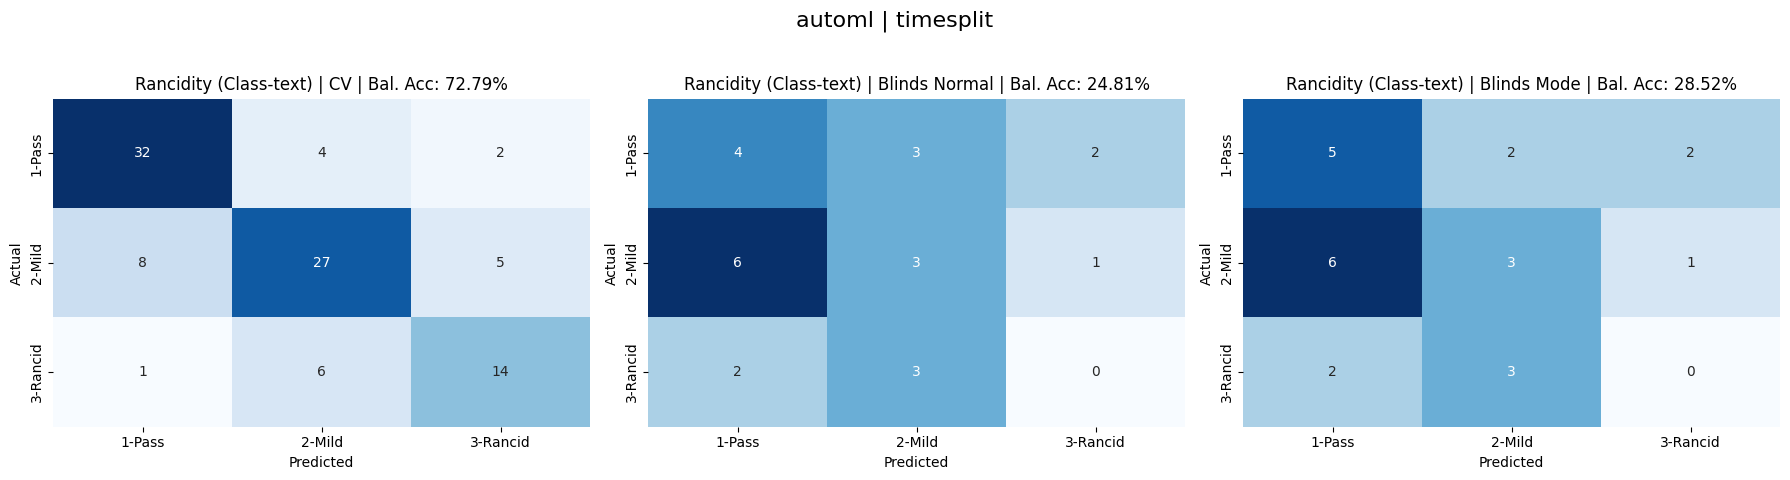

Getting CV scores for Result


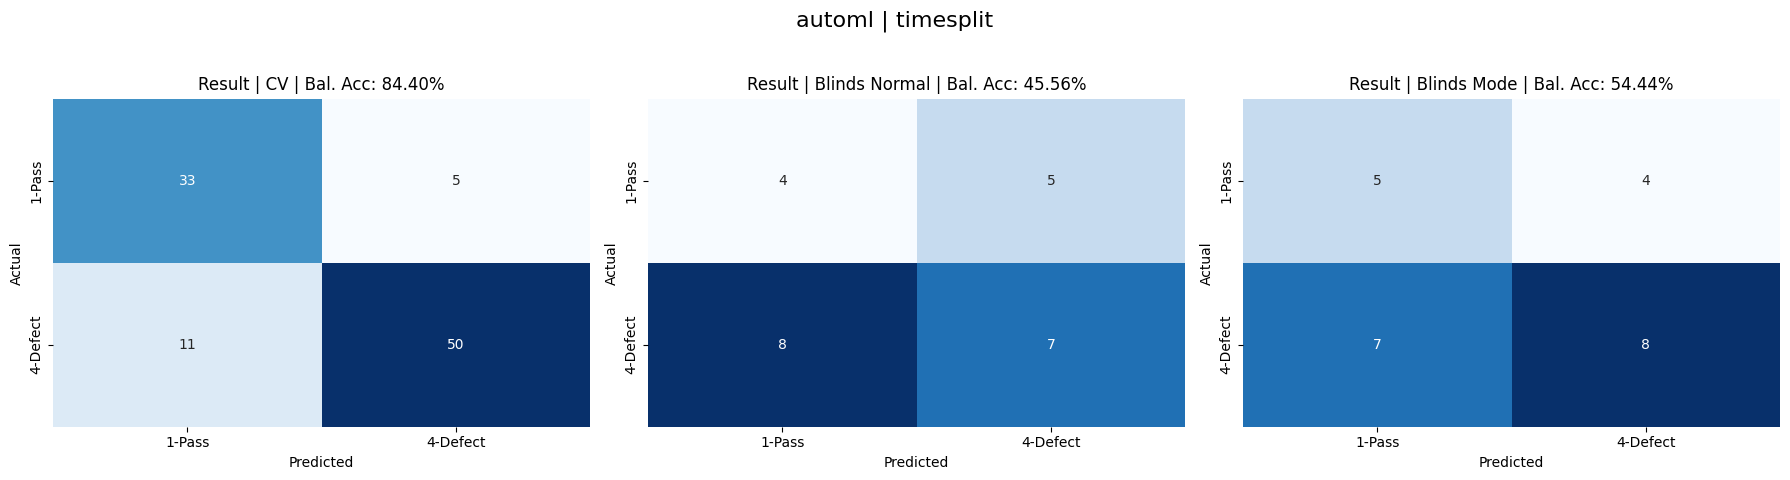

Processing random dataset
Getting CV scores for Rancidity (Class-text)


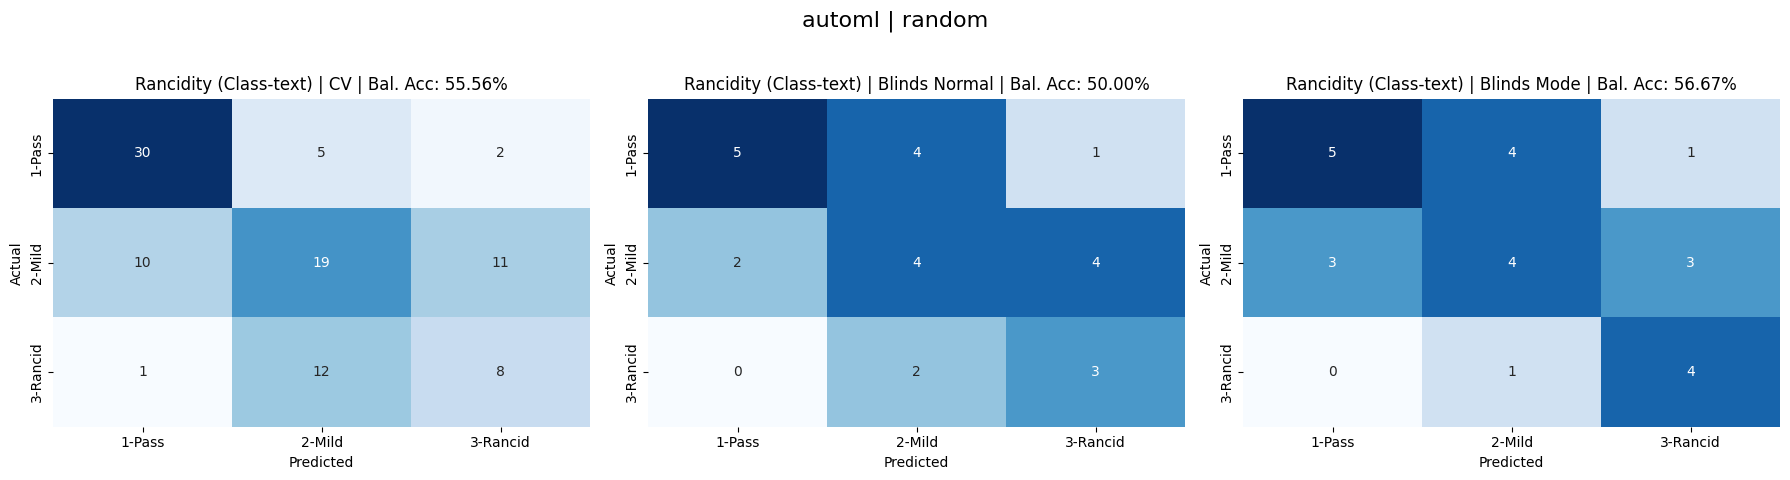

Getting CV scores for Result


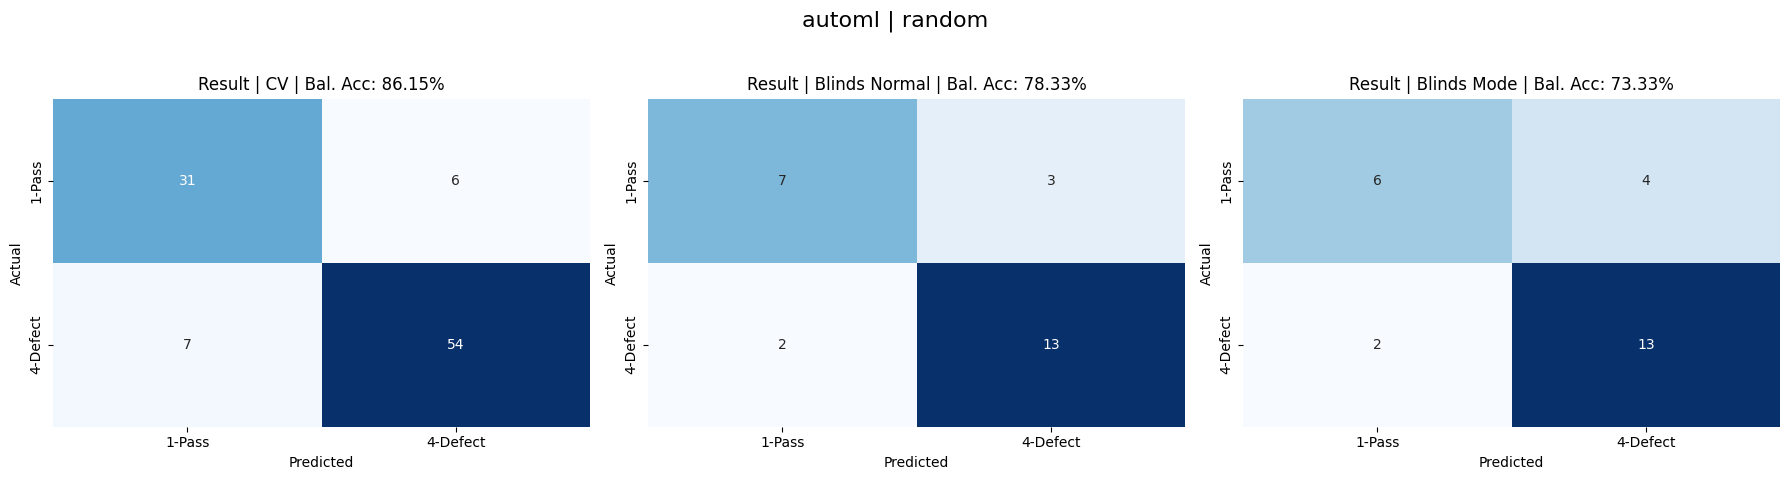

In [ ]:
for dataset in datasets:

    print(f'Processing {dataset} dataset')
    X_train = datasets[dataset]['X_train']
    y_train = datasets[dataset]['y_train']
    X_test = datasets[dataset]['X_test']
    y_test = datasets[dataset]['y_test']

    # Count the number of categorical columns in y_train
    categorical_cols = [col for col in y_train.columns if y_train[col].dtype == 'object']

    for idx, col in enumerate(categorical_cols):

        print(f'Getting CV scores for {col}')
        
        output_dir = Path(f"../models/{model_version}/{dataset}/{col}")
        output_dir.mkdir(parents=True, exist_ok=True)

        selected_y_train = y_train[col]
        selected_y_test = y_test[col]

        # Check if encoder exists
        encoder_path = output_dir / "encoder.pkl"
        if encoder_path.exists():
            encoder = pkl.load(open(encoder_path, "rb"))
            selected_y_train_encoded = pd.Series(
                encoder.transform(selected_y_train),
                index=selected_y_train.index
            )
            selected_y_test_encoded = pd.Series(
                encoder.transform(selected_y_test),
                index = selected_y_test.index
            )
        else:
            print("Encoder does not exist, skipping cv")
            continue

        # Check if model exists
        model_path = output_dir / "trainer.pkl"
        if model_path.exists():
            trainer = pkl.load(open(model_path, "rb"))
        else:
            print("Model does not exist, skipping cv")
            continue

        # predict CV
        grouped_cv_pred = cross_group_predict(
            trainer.get_pipeline(),
            X=X_train,
            y=selected_y_train_encoded,
            cv=StratifiedGroupKFold(n_splits=3),
            groups=X_train.index
        )

        grouped_cv_pred_mode = cross_group_predict_mode(
            trainer.get_pipeline(),
            X=X_train,
            y=selected_y_train_encoded,
            cv=StratifiedGroupKFold(n_splits=3),
            groups=X_train.index
        )

        grouped_y_train = selected_y_train_encoded.groupby(selected_y_train_encoded.index).mean()

        # predict blinds
        ## normal
        grouped_X_test = X_test.groupby(X_test.index).mean()
        val_pred_normal = trainer.predict(grouped_X_test)
        val_predprobab_normal = trainer.predict_proba(grouped_X_test)
        ## mode
        val_pred_mode = classify_mode_pred(trainer.get_pipeline(), X_test)

        grouped_selected_y_test = selected_y_test_encoded.groupby(selected_y_test_encoded.index).mean()

        def plot_cf_matrix(cnfm, ax):
            cnfm_settings = {
                "cmap": "Blues",
                "cbar": False,
                "annot": True,
                "fmt": ".0f",
                "xticklabels": encoder.classes_,
                "yticklabels": encoder.classes_,
            }

            sns.heatmap(cnfm, ax=ax, **cnfm_settings)
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")

        
        ncols = 2  # At 3 columns, for CV, aggregated blinds, mode blinds
        nrows = 2

        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5))
        # fig.suptitle(f"{model_version} | {dataset}", fontsize=16)

        # Get subplot axes
        ax = axes[0,0]
        cnfm = confusion_matrix(grouped_y_train, grouped_cv_pred)
        bal_acc = balanced_accuracy_score(grouped_y_train, grouped_cv_pred)
        ax.set_title(f"{col} | CV Normal | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)
        plot_cf_matrix(cnfm, ax)

        ax = axes[0,1]
        cnfm = confusion_matrix(grouped_selected_y_test, val_pred_normal)
        bal_acc = balanced_accuracy_score(grouped_selected_y_test, val_pred_normal)
        ax.set_title(f"{col} | Blinds Normal | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)
        plot_cf_matrix(cnfm, ax)

        ax = axes[1,0]
        cnfm = confusion_matrix(grouped_y_train, grouped_cv_pred_mode)
        bal_acc = balanced_accuracy_score(grouped_y_train, grouped_cv_pred_mode)
        ax.set_title(f"{col} | CV Mode | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)
        plot_cf_matrix(cnfm, ax)

        ax = axes[1,1]
        cnfm = confusion_matrix(grouped_selected_y_test, val_pred_mode)
        bal_acc = balanced_accuracy_score(grouped_selected_y_test, val_pred_mode)
        ax.set_title(f"{col} | Blinds Mode | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)
        plot_cf_matrix(cnfm, ax)

    # # Hide any empty subplots
    # for idx in range(num_cols, nrows * ncols):  # Only affects extra subplots
    #     fig.delaxes(axes.flatten()[idx])  # Remove empty subplot

        # Adjust layout and save the combined figure
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(f"../models/{model_version}/{dataset}/{col}/cv_metrics_summary.png",bbox_inches = "tight")
        plt.show()
        plt.close()

Processing timesplit dataset


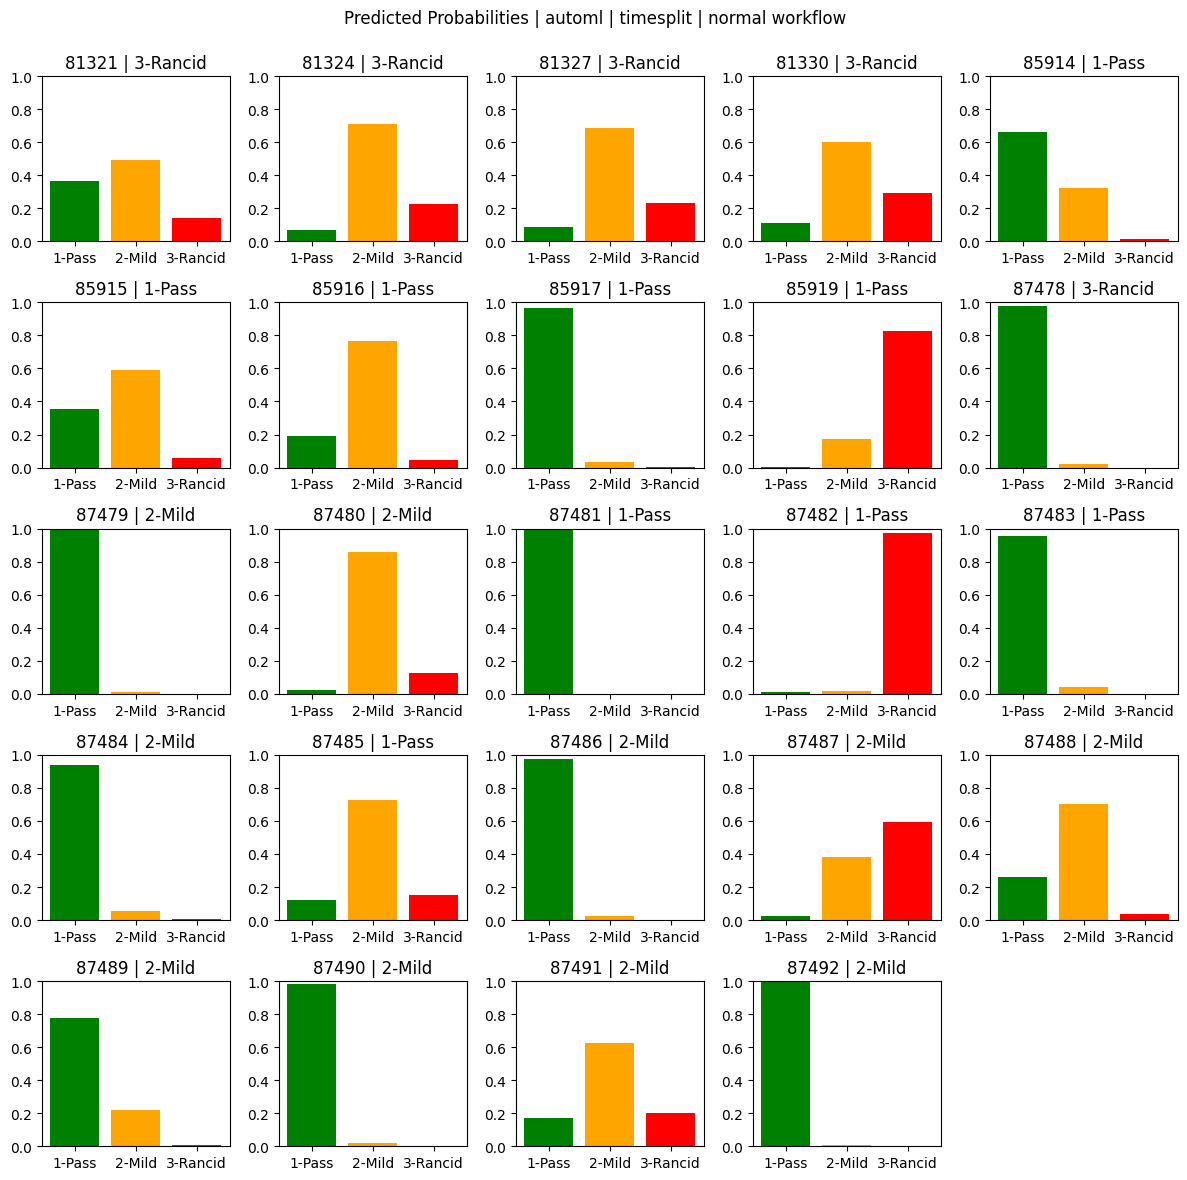

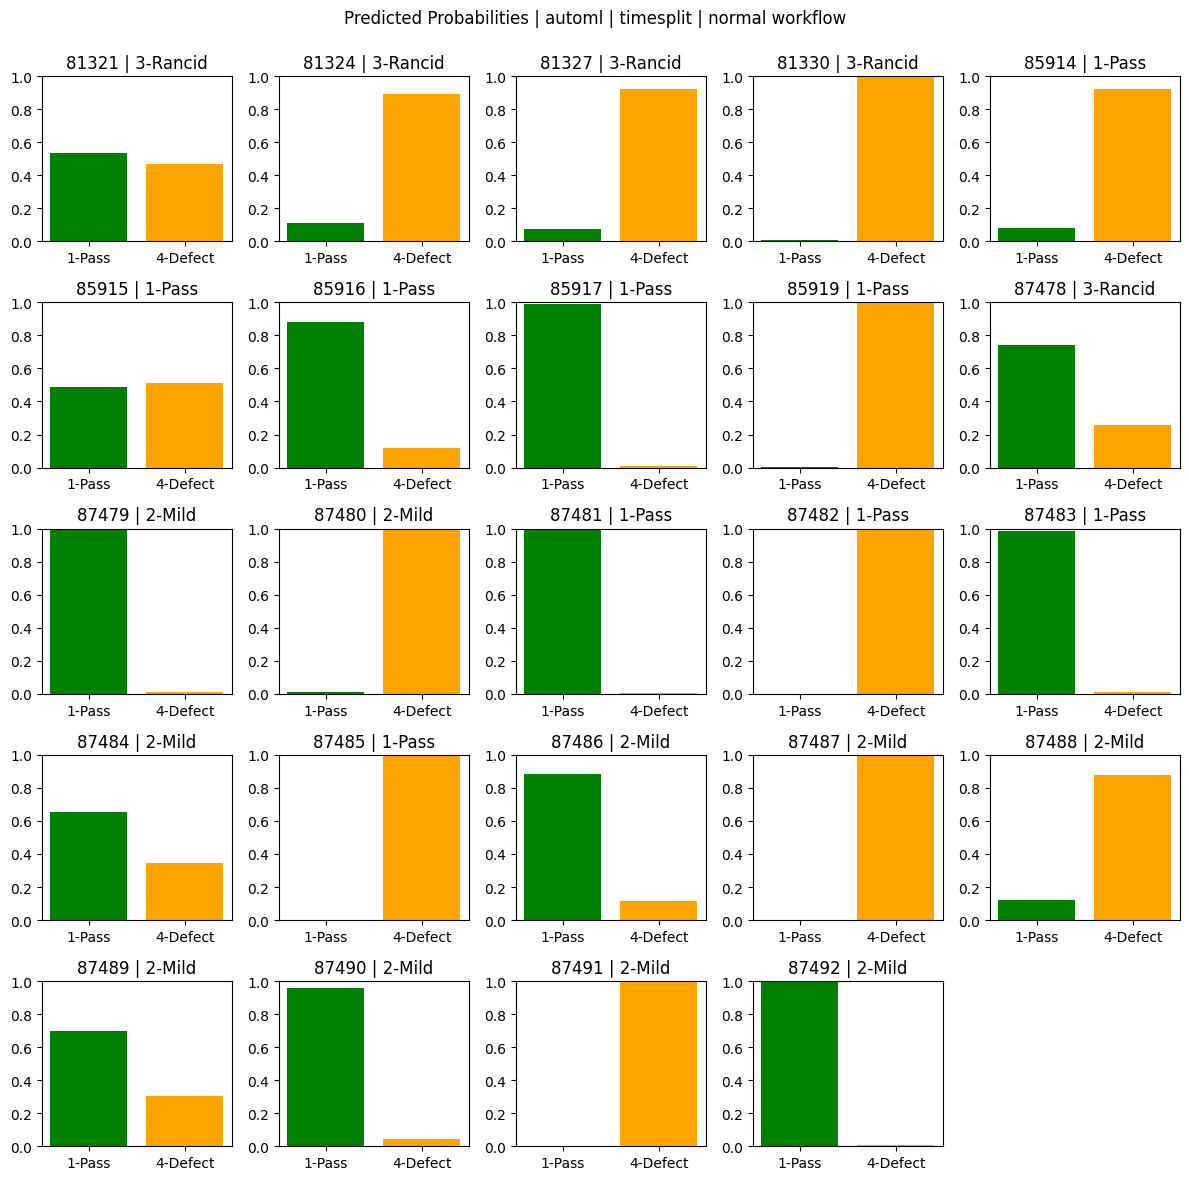

Processing random dataset


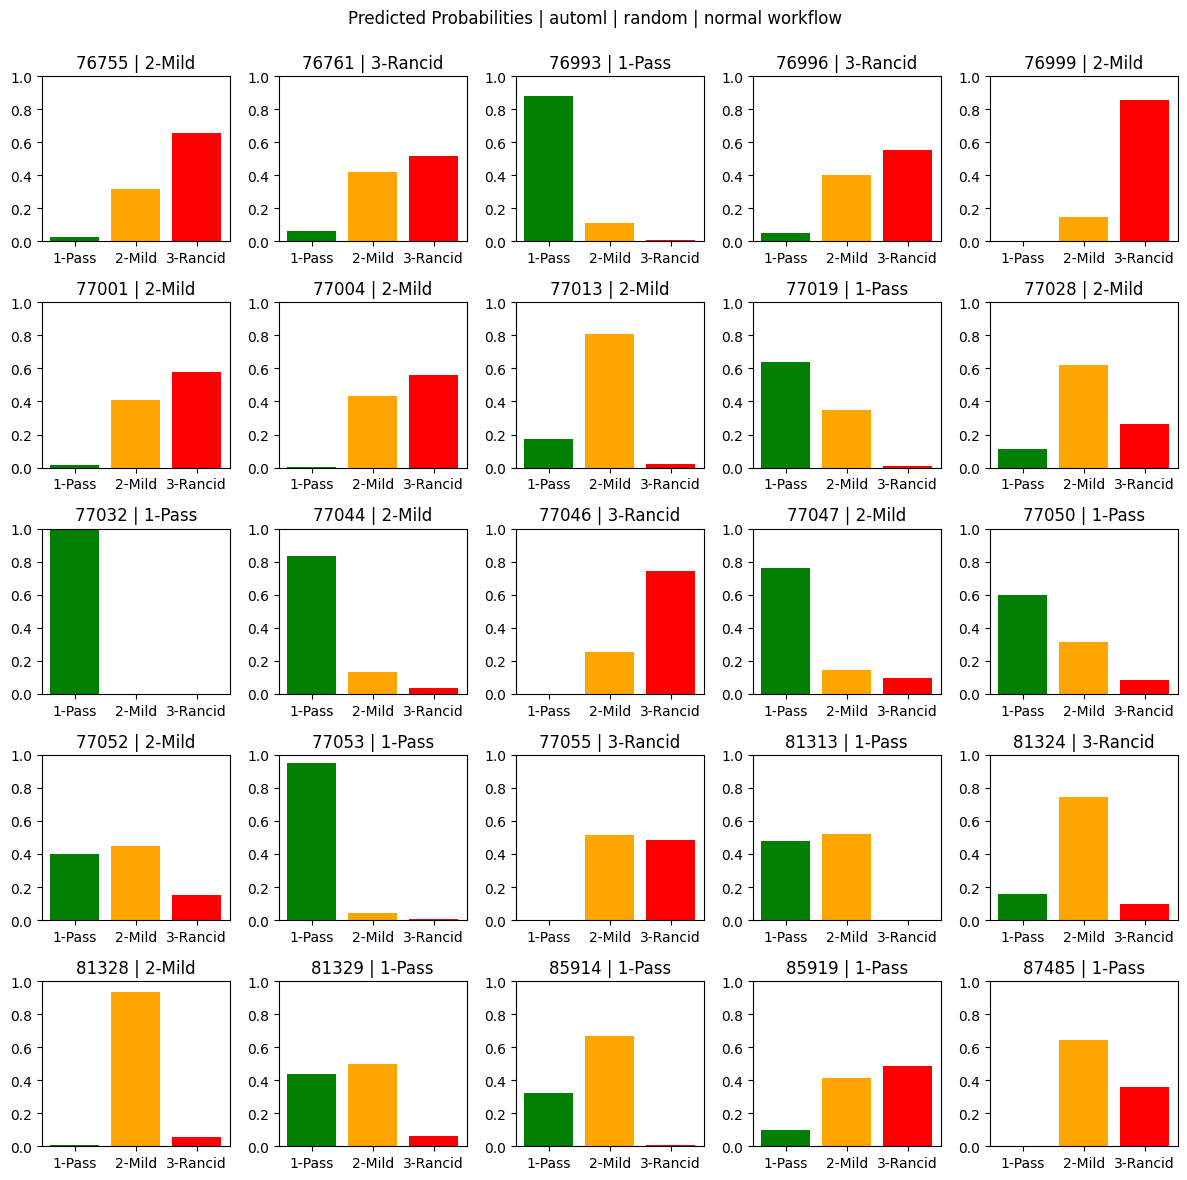

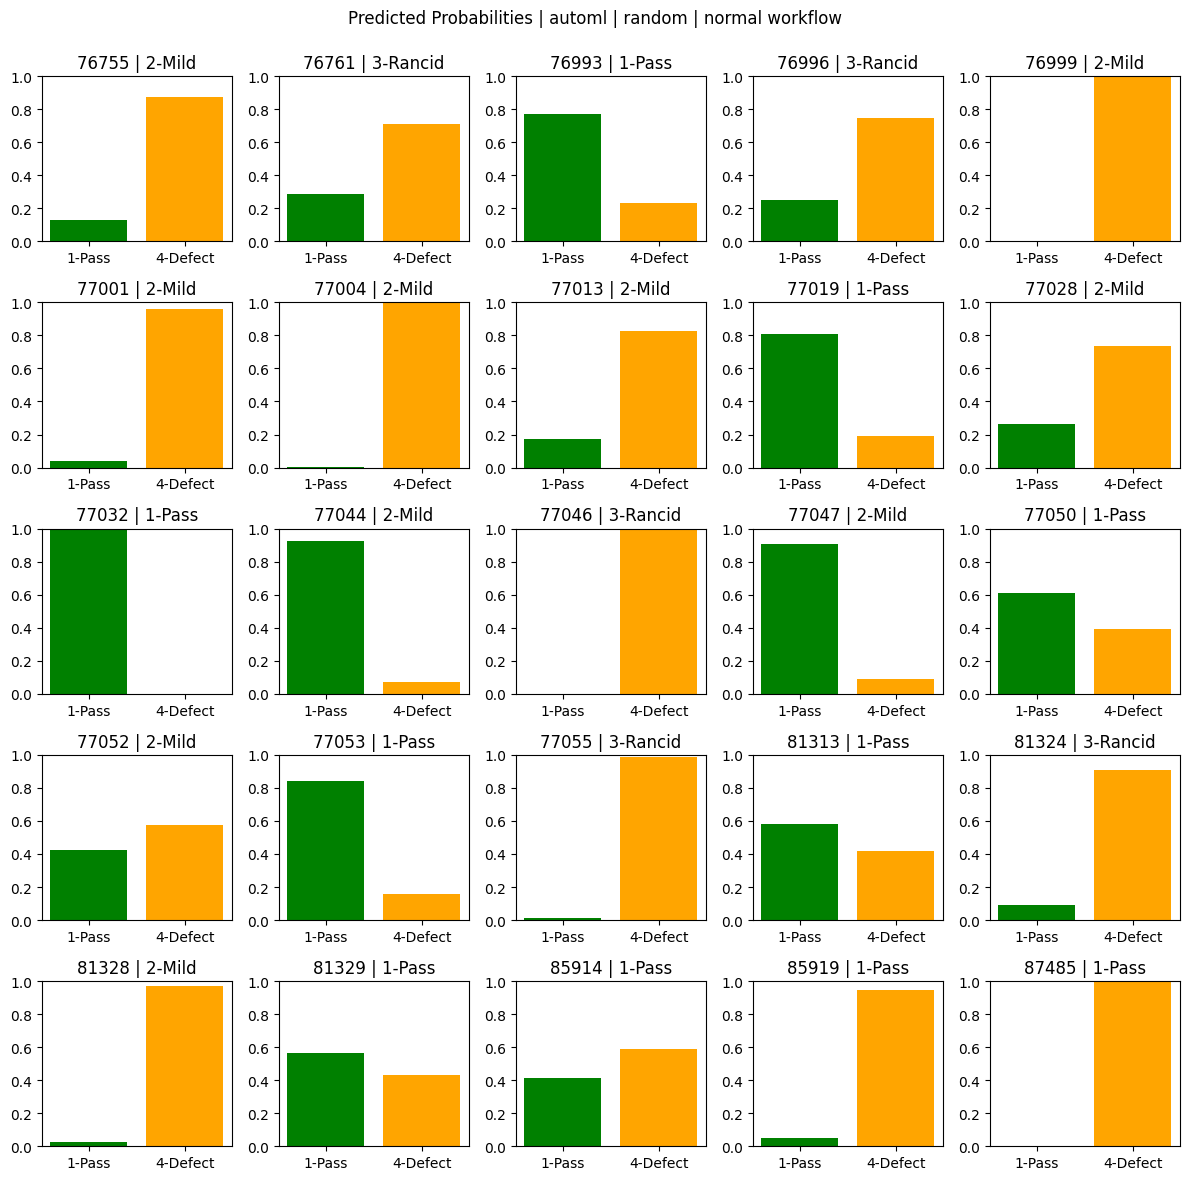

In [30]:
for dataset in datasets:

    print(f'Processing {dataset} dataset')
    X_train = datasets[dataset]['X_train']
    y_train = datasets[dataset]['y_train']
    X_test = datasets[dataset]['X_test']
    y_test = datasets[dataset]['y_test']

    categorical_cols = [col for col in y_train.columns if y_train[col].dtype == 'object']

    for idx, col in enumerate(categorical_cols):

        # if idx>0:
        #     continue
        
        output_dir = Path(f"../models/{model_version}/{dataset}/{col}")
        output_dir.mkdir(parents=True, exist_ok=True)

        selected_y_train = y_train[col]
        selected_y_test = y_test[col]

        # Check if encoder exists
        encoder_path = output_dir / "encoder.pkl"
        if encoder_path.exists():
            encoder = pkl.load(open(encoder_path, "rb"))
            selected_y_train_encoded = pd.Series(
                encoder.transform(selected_y_train),
                index=selected_y_train.index
            )
            selected_y_test_encoded = pd.Series(
                encoder.transform(selected_y_test),
                index = selected_y_test.index
            )
        else:
            print("Encoder does not exist, skipping cv")
            continue

        # Check if model exists
        model_path = output_dir / "trainer.pkl"
        if model_path.exists():
            add_timeout(loss_function,30)
            stopping_criteria(None)
            trainer = pkl.load(open(model_path, "rb"))
        else:
            print("Model does not exist, skipping cv")
            continue


        # predict blinds
        ## normal
        grouped_X_test = X_test.groupby(X_test.index).mean()

        val_predprobab_normal = trainer.predict_proba(grouped_X_test)

        labels = y_test.reset_index().drop_duplicates(keep="first")

        # plot the probability distribution for each row as separate stacked bar charts as subplots
        # Set up a 5x5 grid of subplots
        fig, axes = plt.subplots(5, 5, figsize=(12, 12))
        fig.suptitle(f"Predicted Probabilities | {model_version} | {dataset} | normal workflow\n")

        for i, row in enumerate(val_predprobab_normal):
            r, c = divmod(i, 5)  # Convert index to row/column
            axes[r, c].bar(encoder.classes_, row, color=["green", "orange", "red"])
            axes[r, c].set_title(f"{labels.iloc[i, 0]} | {labels.iloc[i, 1]}")
            axes[r, c].set_ylim(0, 1)  # Ensure all bars are scaled properly

        # Remove unused subplots if fewer than 25 rows
        for j in range(i+1, 25):
            r, c = divmod(j, 5)
            fig.delaxes(axes[r, c])  # Remove empty plots

        plt.tight_layout()
        plt.savefig(f"../models/{model_version}/{dataset}/{col}/blinds_predict_proba.png",bbox_inches = "tight")
        plt.show()
        plt.close()

# cross val predict

## summarised cfm

In [14]:
# for dataset in datasets:

#     print(f'Processing {dataset} dataset')
#     X_train = datasets[dataset]['X_train']
#     y_train = datasets[dataset]['y_train']

#     # Count the number of categorical columns in y_train
#     categorical_cols = [col for col in y_train.columns if y_train[col].dtype == 'object']
#     num_cols = len(categorical_cols)

#     # Set up subplot grid size dynamically
#     ncols = min(3, num_cols)  # At most 3 columns per row
#     nrows = int(np.ceil(num_cols / ncols))  # Compute the number of rows

#     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5))
#     fig.suptitle(f"Cross Validation Confusion Matrices for {dataset} dataset", fontsize=16)

#     if nrows == 1 and ncols == 1:
#         axes = np.array([[axes]])  # Make it a 2D array for consistency
#     elif nrows == 1:
#         axes = np.array([axes])  # Convert 1D array to 2D
#     elif ncols == 1:
#         axes = np.array([[ax] for ax in axes])  # Convert to 2D array

#     for idx, col in enumerate(categorical_cols):

#         # if idx>0:
#         #     continue

#         print(f'Getting CV scores for {col}')
        
#         output_dir = Path(f"../models/{model_version}/{dataset}/{col}")
#         output_dir.mkdir(parents=True, exist_ok=True)
#         selected_y_train = y_train[col]

#         # Check if encoder exists
#         encoder_path = output_dir / "encoder.pkl"
#         if encoder_path.exists():
#             encoder = pkl.load(open(encoder_path, "rb"))
#             selected_y_train_encoded = pd.Series(
#                 encoder.transform(selected_y_train),
#                 index=selected_y_train.index
#             )
#         else:
#             print("Encoder does not exist, skipping cv")
#             continue

#         # Check if model exists
#         model_path = output_dir / "trainer.pkl"
#         if model_path.exists():
#             add_timeout(loss_function,30)
#             stopping_criteria(None)
#             trainer = pkl.load(open(model_path, "rb"))
#         else:
#             print("Model does not exist, skipping cv")
#             continue

#         grouped_X = X_train.groupby(X_train.index).mean()
#         grouped_y = selected_y_train_encoded.groupby(selected_y_train_encoded.index).mean()

#         # Calculate CV confusion matrix
#         kfold = StratifiedGroupKFold(n_splits=3)

#         grouped_cv_pred = cross_group_predict(
#             trainer.get_pipeline(),
#             X=X_train,
#             y=selected_y_train_encoded,
#             cv=kfold,
#             groups=X_train.index
#         )

#         cnfm = confusion_matrix(grouped_y, grouped_cv_pred)
#         bal_acc = balanced_accuracy_score(grouped_y, grouped_cv_pred)

#         # Get subplot axes
#         ax = axes[idx // ncols, idx % ncols]

#         ax.set_title(f"{col} | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)

#         cnfm_settings = {
#             "cmap": "Blues",
#             "cbar": False,
#             "annot": True,
#             "fmt": ".0f",
#             "xticklabels": encoder.classes_,
#             "yticklabels": encoder.classes_,
#         }

#         sns.heatmap(cnfm, ax=ax, **cnfm_settings)
#         ax.set_xlabel("Predicted")
#         ax.set_ylabel("Actual")

#     # Hide any empty subplots
#     for idx in range(num_cols, nrows * ncols):  # Only affects extra subplots
#         fig.delaxes(axes.flatten()[idx])  # Remove empty subplot

#     # Adjust layout and save the combined figure
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig(f"../models/{model_version}/{dataset}/cv_metrics_summary.png",bbox_inches = "tight")
#     plt.show()
#     plt.close()

## individual cfm

In [ ]:
# for dataset in datasets:
#     print(f'Processing {dataset} dataset')
#     X_train = datasets[dataset]['X_train']
#     y_train = datasets[dataset]['y_train']

#     for col in y_train.columns:
#         if y_train[col].dtype != 'object':
#             continue
#         elif col == 'date_scanned':
#             continue
#         elif col == 'Result' and model_version == "custom_chain":
#             continue
#         print(f'Getting cv scores for {col}')
        
#         output_dir = Path(f"../models/{model_version}/{dataset}/{col}")
#         output_dir.mkdir(parents=True, exist_ok=True)
#         selected_y_train = y_train[col]

#         #check if encoder exists
#         if (output_dir / "encoder.pkl").exists():
#             encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
#             selected_y_train_encoded = pd.Series(
#                 encoder.transform(selected_y_train),
#                 index = selected_y_train.index
#             )
#         else:
#             print("Encoder does not exist, skipping cv")

#         # check if model exists
#         if (output_dir / "trainer.pkl").exists():
#             trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
#         else:
#             print("Model does not exist, skipping cv")

#         grouped_X = X_train.groupby(X_train.index).mean()
#         grouped_y = selected_y_train_encoded.groupby(selected_y_train_encoded.index).mean()

#         # Calculate CV confusion matrix
#         kfold = StratifiedGroupKFold(n_splits = 3)

#         grouped_cv_pred = cross_group_predict(
#             trainer.get_pipeline(),
#             X = X_train,
#             y = selected_y_train_encoded,
#             cv = kfold,
#             groups = X_train.index
#         )

#         cnfm = confusion_matrix(grouped_y, grouped_cv_pred)
#         bal_acc = balanced_accuracy_score(grouped_y, grouped_cv_pred)

#         fig = plt.figure(figsize = (6, 4))
#         fig.suptitle(f"{col} | Cross Validation | {dataset}")
#         ax = fig.add_subplot(111)

#         ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

#         cnfm_settings = {
#             "cmap": "Blues",
#             "cbar": None,
#             "annot": True,
#             "fmt": ".0f",
#             "xticklabels": encoder.classes_,
#             "yticklabels": encoder.classes_,
#         }

#         sns.heatmap(
#             cnfm,
#             ax = ax,
#             **cnfm_settings
#         )

#         ax.set_xlabel('Predicted')
#         ax.set_ylabel('Actual')

#         # plt.tight_layout()
#         plt.savefig(output_dir / f"cv_metrics_{dataset}_{col}.png", bbox_inches = "tight")
#         # plt.show()
#         plt.close()


# blinds predict

## individual cfm

In [ ]:
# for dataset in datasets:
#     print(f'Processing {dataset} dataset')
#     X_test = datasets[dataset]['X_test']
#     y_test = datasets[dataset]['y_test']

#     for col in y_test.columns:
#         if y_test[col].dtype != 'object':
#             continue
#         elif col == 'date_scanned':
#             continue
#         elif col == 'Result' and model_version == "custom_chain":
#             continue
#         print(f'Getting test scores for {col}')
        
#         output_dir = Path(f"../models/{model_version}/{dataset}/{col}")
#         output_dir.mkdir(parents=True, exist_ok=True)
#         selected_y_test = y_test[col]

#         #check if encoder exists
#         if (output_dir / "encoder.pkl").exists():
#             encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
#             selected_y_test_encoded = pd.Series(
#                 encoder.transform(selected_y_test),
#                 index = selected_y_test.index
#             )
#         else:
#             print("Encoder does not exist, skipping test")

#         # check if model exists
#         if (output_dir / "trainer.pkl").exists():
#             trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
#         else:
#             print("Model does not exist, skipping test")

#         grouped_X_test = X_test.groupby(X_test.index).mean()
#         grouped_selected_y_test = selected_y_test_encoded.groupby(selected_y_test_encoded.index).mean()

#         val_pred = trainer.predict(grouped_X_test)

#         cnfm = confusion_matrix(grouped_selected_y_test, val_pred)
#         bal_acc = balanced_accuracy_score(grouped_selected_y_test, val_pred)

#         fig = plt.figure(figsize = (6, 4))
#         fig.suptitle(f"{col} | Blinds | {dataset}")
#         ax = fig.add_subplot(111)

#         ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

#         cnfm_settings = {
#             "cmap": "Blues",
#             "cbar": None,
#             "annot": True,
#             "fmt": ".0f",
#             "xticklabels": encoder.classes_,
#             "yticklabels": encoder.classes_,
#         }

#         sns.heatmap(
#             cnfm,
#             ax = ax,
#             **cnfm_settings
#         )

#         ax.set_xlabel('Predicted')
#         ax.set_ylabel('Actual')

#         # plt.tight_layout()
#         plt.savefig(output_dir / f"blinds_metrics_{dataset}_{col}.png", bbox_inches = "tight")
#         # plt.show()
#         plt.close()